In [1]:
#File for figure 4 and 5, can run all code for figures 4 and 5.

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import io
import scipy.io as sio
import pandas as pd
import os

In [2]:
#Write the path to the txt folder to be analysed
folderpath= input("Simulation folder path?")

Simulation folder path?./COPASI_simulations/Li_2012_modelling/frequency_scan_fig6b/scan1D_freq_20.txt


In [3]:
#Downloads the data from COPASI, into a table
df = pd.read_csv(folderpath, sep='\s+', index_col = False)

print(df.columns)

df

Index(['Values[spikeFrequency].InitialValue', 'Time', 'Values[AMPAR_bar]',
       'Values[CaMKII_active_ratio]', 'Values[CaMKII_active_total]',
       'Values[k_AMPAR_phsophorylation]', 'Values[k_AMPARp_dephosphorylation]',
       'Values[PKA_bar]', 'Values[PP1a_bar]', 'Values[PP1a_total]',
       'Values[PP2B_bar]', '[AMPAR]', '[CaMKIIp]', '[CaMKIIp_PP1a]', '[Ca]',
       '[Dp]'],
      dtype='object')


,Values[spikeFrequency].InitialValue,Time,Values[AMPAR_bar],Values[CaMKII_active_ratio],Values[CaMKII_active_total],Values[k_AMPAR_phsophorylation],Values[k_AMPARp_dephosphorylation],Values[PKA_bar],Values[PP1a_bar],Values[PP1a_total],Values[PP2B_bar],[AMPAR],[CaMKIIp],[CaMKIIp_PP1a],[Ca],[Dp]
0,0.1,800.000,0.175631,0.033852,0.000002,0.012968,0.060866,0.01,0.199263,3.985260e-07,0.035107,0.000001,7.201100e-11,3.195290e-11,1.010100e-08,4.331020e-07
1,0.1,800.001,0.175631,0.033853,0.000002,0.012968,0.060866,0.01,0.199263,3.985260e-07,0.035107,0.000001,7.201100e-11,3.195290e-11,1.622130e-07,4.331020e-07
2,0.1,800.002,0.175631,0.033853,0.000002,0.012968,0.060866,0.01,0.199263,3.985260e-07,0.035108,0.000001,7.201090e-11,3.195290e-11,2.383200e-07,4.331020e-07
3,0.1,800.003,0.175631,0.033855,0.000002,0.012969,0.060866,0.01,0.199263,3.985260e-07,0.035110,0.000001,7.201080e-11,3.195290e-11,3.149810e-07,4.331020e-07
4,0.1,800.004,0.175631,0.033858,0.000002,0.012970,0.060866,0.01,0.199263,3.985260e-07,0.035114,0.000001,7.201060e-11,3.195290e-11,3.919940e-07,4.331020e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2520016,200.0,919.996,0.123404,0.042302,0.000003,0.016189,0.119552,0.01,0.376576,7.531530e-07,0.038649,0.000001,4.059660e-11,3.421390e-11,1.011640e-08,1.812770e-07
2520017,200.0,919.997,0.123404,0.042302,0.000003,0.016189,0.119551,0.01,0.376574,7.531470e-07,0.038649,0.000001,4.059600e-11,3.421310e-11,1.011630e-08,1.812790e-07
2520018,200.0,919.998,0.123403,0.042302,0.000003,0.016189,0.119551,0.01,0.376571,7.531410e-07,0.038648,0.000001,4.059530e-11,3.421230e-11,1.011630e-08,1.812810e-07
2520019,200.0,919.999,0.123403,0.042301,0.000003,0.016189,0.119550,0.01,0.376568,7.531350e-07,0.038648,0.000001,4.059470e-11,3.421160e-11,1.011630e-08,1.812830e-07


In [4]:
#Select given columns to analyse, in this case activated CaMKII, calcineurin and PP1
#All values are normalized with respect to total amounts (bar value)
CaMKII_active_values = df['Values[CaMKII_active_ratio]'] 
PP2B_active_values = df['Values[PP2B_bar]'] 
PP1_active_values = df['Values[PP1a_bar]'] 
AMPA_bar = df["Values[AMPAR_bar]"]
time = df["Time"]

#Find indices of change in frequency values
freq = df["Values[spikeFrequency].InitialValue"]
unique_f, indices_f = np.unique(freq, return_index = True)

#Compute time constants
stepsize = indices_f[1]-1
simulation_time = time[indices_f[1]-1]-time[0]
dt = time[1] - time[0]

print(stepsize)
print(simulation_time)
print(dt)

#catalytic constants, all defined in seconds^-1 as in Li et al., (2012)
kk_GluR1 = 0.5
k_pp2b_GluR1 = 2.0
k_pp1_GluR1 = 0.35

120000
120.0
0.00100000000009004


In [5]:
#Computes the activated area of each species as described in the methods, using the trapezoidal rule and subtracting the baseline
def activated_area (values, simulation_t):
    t_values = np.linspace(0, np.int(simulation_t), num = values.size) #defines the array of t_values based on the stepsize
    baseline = values[0]*simulation_t #substracts the baseline to calculate the activated area
    trapezium_sum_baseline = np.trapz(values,t_values) #integrates using the composite trapezoid rule, baseline included
  
    if baseline > 0:
        trapezium_sum = trapezium_sum_baseline - baseline #subtracts baseline to approximation
        return trapezium_sum
    else:
        return trapezium_sum_baseline

In [6]:
#Given an array of values, it computes the activated area for each frequency
def split_frequencies(indices, values, simulation_t):
    freq_matrix = np.reshape(np.array(values), (indices.shape[0],indices[1]), order = "C") #creates an empty matrix to add the values of the split array
    activated_area_arr = np.zeros((indices.shape[0],1)) #creates an empty array to store the values of the activated area
    for i in range(freq_matrix.shape[0]):
        activated_area_arr[i] = activated_area(freq_matrix[i,:], simulation_t)#computes the activated area of each of the frequencies
    return activated_area_arr

In [7]:
#Given 2 phosphatases and a kinase it computes the direction and magnitude of plasticity as a function of frequency
def LTP_LTD_ratio (phosphatase1,phosphatase2, kinase, indices, simulation_t, kp1, kp2, kk):
    activated_phosphatase1 = split_frequencies(indices, phosphatase1, simulation_t) #generates the activated area values for phosphatase1
    activated_phosphatase2 = split_frequencies(indices, phosphatase2, simulation_t) #generates the activated area values for the phosphatase2
    activated_kinase = split_frequencies(indices, kinase, simulation_t) #generates the activated area values for the phosphatase
    activity_difference = activated_kinase*kk - activated_phosphatase1*kp1 - activated_phosphatase2*kp2 #calculates the activated area difference (defined in Li et al 2012)
    return activity_difference

In [9]:
#rearranges a matrix of values based on the parameter scan value
def split_values(indices, values):
        values_matrix = np.reshape(np.array(values), (indices.shape[0],indices[1]), order = "C") #creates an empty matrix to add the values of the split array
        return values_matrix

In [9]:
A = np.matrix(PP2B_active_values)
B = np.append(A,np.matrix(PP1_active_values), axis = 0)

B.shape

(2, 2520021)

LFS = 1.43008Hz
HFS = 43.7345Hz
LFS duration = 69.9261579771761s
HFS duartion = 2.286524368633459s


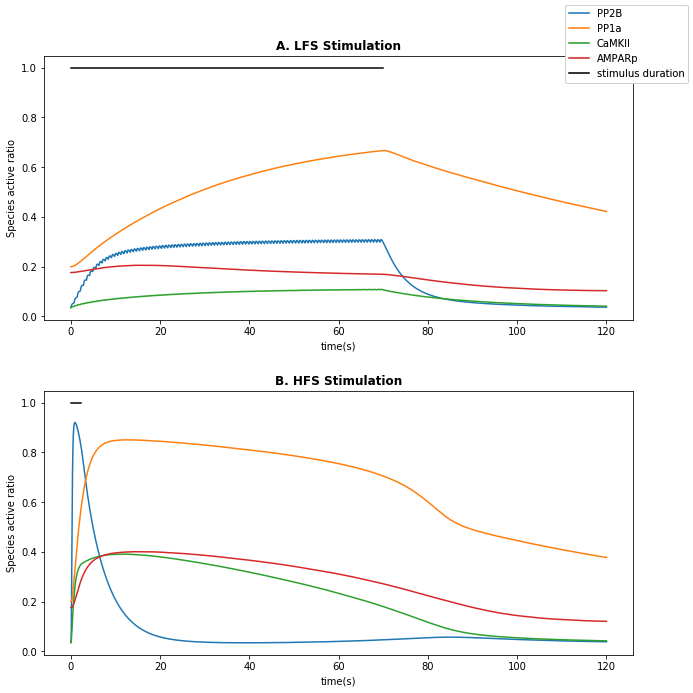

In [10]:
#Figure 4: activation profile of CaMKII, PP2B, PP1a and AMPARp for and arbitrary LFS (1.43 Hz) and HFS (43.73 Hz)

#defines the LFS and HFS value to plot
LFS = unique_f[7] 
HFS = unique_f[16]

print("LFS = "+ str(LFS)+"Hz")
print("HFS = "+ str(HFS)+"Hz")

spike_number = 100 #defined specifically for this simulation file
LFS_duration = (1/LFS)*spike_number
HFS_duration = (1/HFS)*spike_number

print("LFS duration = "+ str(LFS_duration)+"s")
print("HFS duartion = "+ str(HFS_duration)+"s")

PP2B = split_values(indices_f, PP2B_active_values)
PP1a = split_values(indices_f, PP1_active_values)
CaMKII = split_values(indices_f, CaMKII_active_values)
AMPAR = split_values(indices_f, AMPA_bar)

#activation profile of CaMKII, PP2B, PP1a and AMPARp for LFS (1.43 Hz) and HFS (43.73 Hz)

fig, (ax1, ax2) = plt.subplots(2,figsize=(10,10))
fig.tight_layout(pad=5.0)

x = np.linspace(0, simulation_time, num = np.ceil(simulation_time/dt)+1) #simulation for 120 seconds with 1e-3 time step
#LFS plot
ax1.plot(x, PP2B[7],label="PP2B")
ax1.plot(x, PP1a[7],label="PP1a")
ax1.plot(x, CaMKII[7],label="CaMKII")
ax1.plot(x, AMPAR[7], label="AMPARp")
ax1.plot([0, LFS_duration], [1, 1], 'k-', label="stimulus duration")
fig.legend()
ax1.set_title("A. LFS Stimulation", fontweight="bold")

#HFS plot
ax2.plot(x, PP2B[16])
ax2.plot(x, PP1a[16])
ax2.plot(x, CaMKII[16])
ax2.plot(x, AMPAR[16])
ax2.plot([0, HFS_duration], [1, 1], 'k-')
ax2.set_title("B. HFS Stimulation", fontweight="bold")

fig.legend()

for ax in (ax1,ax2):
    ax.set(xlabel='time(s)', ylabel='Species active ratio')


Text(0.5, 0, 'Calcium Spike Frequency (Hz)')

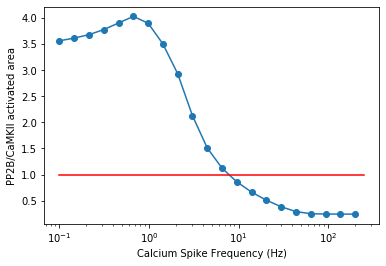

In [11]:
#Figure 5A: Calcineurin/CaMKII activated area, replicating figure 6a in Li et al., (2012)

#computes the activated area of calcineurin and CaMKII
AA_PP2B = split_frequencies(indices_f, PP2B_active_values, simulation_time)
AA_PP1a = split_frequencies(indices_f, PP1_active_values, simulation_time)
AA_CaMKII = split_frequencies(indices_f, CaMKII_active_values, simulation_time)

#computes the activated area ratio
AA_ratio = AA_PP2B/AA_CaMKII

#plot in logscale
plt.plot(np.logspace(-1, np.log10(200), num = unique_f.shape[0]), AA_ratio, "-o")
plt.xscale("log")
plt.plot([0.1, 2.5e2], [1, 1], 'r-')
plt.ylabel('PP2B/CaMKII activated area')
plt.xlabel('Calcium Spike Frequency (Hz)')

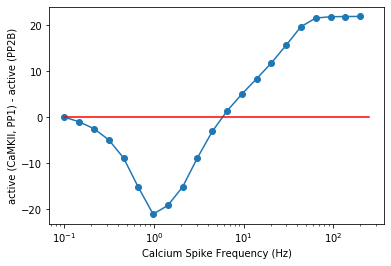

In [15]:
#Figure 5B: LTD to LTP shift based on kinase and phosphatase activation, replicating figure 6b in Li et al., (2012) 
#adding PP1a instead of subtracting it

#compute the results of the ratio of LTP and LTD
ratio_results = LTP_LTD_ratio (PP1_active_values, PP2B_active_values, CaMKII_active_values, indices_f, simulation_time, -1*k_pp1_GluR1, k_pp2b_GluR1, kk_GluR1)
ratio_results_normalized = ratio_results - ratio_results[0] #subtract the baseline

#plot in logscale
plt.plot(np.logspace(-1, np.log10(200), num = unique_f.shape[0]), ratio_results_normalized, "-o")
plt.xscale("log")
plt.plot([0.1, 2.5e2], [0, 0], 'r-')
plt.xlabel('Calcium Spike Frequency (Hz)')
plt.ylabel('active (CaMKII, PP1) - active (PP2B)')
plt.show()

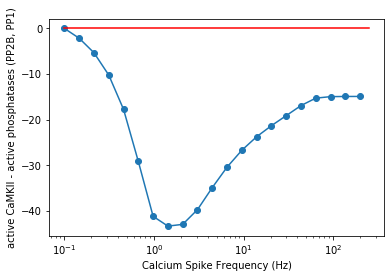

In [14]:
#Figure 5C: LTD to LTP shift based on kinase and phosphatase activation, subtracting PP1a instead of adding it 

#compute the results of the ratio of LTP and LTD
ratio_results = LTP_LTD_ratio (PP1_active_values, PP2B_active_values, CaMKII_active_values, indices_f, simulation_time, k_pp1_GluR1, k_pp2b_GluR1, kk_GluR1)
ratio_results_normalized = ratio_results - ratio_results[0] #subtract the baseline

#plot in logscale
plt.plot(np.logspace(-1, np.log10(200), num = unique_f.shape[0]), ratio_results_normalized, "-o")
plt.xscale("log")
plt.plot([0.1, 2.5e2], [0, 0], 'r-')
plt.xlabel('Calcium Spike Frequency (Hz)')
plt.ylabel('active CaMKII - active phosphatases (PP2B, PP1)')
plt.show()
